 Mehrad

# Scale Invariance in Convolutional Neural Network

# Abstract

Convolutional Neural Networks (ConvNets) have shown excellent results on many
visual classification tasks. Even though convolutional neural networks (CNN) has
achieved near-human performance in various computer vision tasks, its ability to tolerate scale variations is limited [2].

Except some certain datasets like ImageNet, which are
carefully crafted such that objects are well-aligned at similar scales, naturally, the
feature learning problem gets more challenging as the amount of variation in the
data increases, as the models have to learn to be invariant to certain changes in
appearance. Recent results on the ImageNet dataset show that given enough data,
ConvNets can learn such invariances producing very discriminative features [1].
But could we do more: use less parameters, less data, learn more discriminative
features, if certain invariances were built into the learning process?

Below, we are going to fisrt, run the LeNet5 model with MNIST dataset, then to investiate scale invariance problem in CNN models, we will define some functions to scale images then test the pre-trained model with scaled images.

# Importing Libraries

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets.mnist import MNIST
from torch.autograd import Variable
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import math
import seaborn as sns
import pandas as pd
from PIL import Image
#from skimage.transform.radon_transform import fft
from scipy import fftpack
%matplotlib inline

# Arguments

In [2]:
args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=20  # The number of Epochs is the number of times you go 
                   # through the full dataset. 
args['lr']=0.01 # Learning rate is how fast it will decend. 
args['momentum']=0.5 # SGD momentum (default: 0.5) Momentum is a moving 
                     # average of our gradients (helps to keep direction).

args['seed']=1 # random seed
args['log_interval']=40
args['cuda']=True # False if you don't have a CUDA w/ NVIDIA GPU available.
args['train_now']=False

# Model Architecture
Our model is a LeNet5 CNN model which has 3 convolutional layers as the feature extractor part and 3 fully connected layers as the classifier.

In [3]:
class LeNet5(nn.Module):          
     
    def __init__(self):     
        super(LeNet5, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given 
        # as input. Hence padding of 2 is done below)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                                     kernel_size=5, stride=1, padding=2)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, 
                                     kernel_size=5, stride=1, padding=2)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, 
                                     kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(7*7*120, 120)
        # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = nn.Linear(120, 84)       
        # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = nn.Linear(84, 10)        
        # convert matrix with 84 features to a matrix of 10 features (columns)

            
    def forward(self, x):
        # convolve, then perform ReLU non-linearity
        x = F.relu(self.conv1(x))  
        # max-pooling with 2x2 grid 
        x = self.max_pool_1(x) 
        # Conv2 + ReLU
        x = F.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # Conv3 + ReLU
        x = F.relu(self.conv3(x))
        x = x.view(-1, 7*7*120)
        # FC-1, then perform ReLU non-linearity
        x = F.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = F.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)


In [4]:
model = LeNet5()
if args['cuda']:
    model.cuda()

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 14, 14]           2,416
         MaxPool2d-4             [-1, 16, 7, 7]               0
            Conv2d-5            [-1, 120, 7, 7]          48,120
            Linear-6                  [-1, 120]         705,720
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 767,426
Trainable params: 767,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 2.93
Estimated Total Size (MB): 3.05
----------------------------------------------------------------


# Data
Here we import the data using Dataloader

In [5]:
!pwd

/home/mehrad/Projects/AI_and_Decision_Making/CNN-Scale_Invariant


In [6]:
data_train = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                        ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
     
data_test = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False, **kwargs)


# DefiningTrain and Test 

In [7]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(data_train):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. 
        # It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_train.dataset),
                100. * batch_idx / len(data_train), loss.data))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in data_test:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad(): # volatile was removed and now 
            # has no effect. Use `with torch.no_grad():` instead.
            data= Variable(data)
        target = Variable(target)
        output = model(data)
        # sum up batch loss # size_average and reduce args will 
        # be deprecated, please use reduction='sum' instead.
        test_loss += F.nll_loss(output, target, reduction='sum').data 
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(data_test.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_test.dataset),
        100. * correct / len(data_test.dataset)))

# Oprimizer and Loss Function

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# Train and Test LeNet5 on MNIST data set

In [9]:
!pwd

/home/mehrad/Projects/AI_and_Decision_Making/CNN-Scale_Invariant


In [10]:
args['train_now']=True
args['epochs']=10
if args['train_now']:
    for epoch in range (1, args['epochs']+1):
        train(epoch)
        test()
    torch.save(model.state_dict(),'./model/lenet5_MNIST.pytrh' )
else:
    if args['cuda']:
        device = torch.device("cuda")
        model.load_state_dict(torch.load('./model/lenet5_MNIST.pytrh'))
        model.to(device)
    else:
        model.load_state_dict(torch.load('./model/lenet5_MNIST.pytrh'))
    model.eval()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303134
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.173014

Test set: Average loss: 0.1172, Accuracy: 9624/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.093408
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.072655

Test set: Average loss: 0.0550, Accuracy: 9825/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.064287
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.041113

Test set: Average loss: 0.0454, Accuracy: 9852/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.052396
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.043145

Test set: Average loss: 0.0451, Accuracy: 9863/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.079682
Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.020314

Test set: Average loss: 0.0317, Accuracy: 9905/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.016700
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.034693

Test set: Average loss: 0.0361, Accuracy: 9884/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.025204
Train Epoch: 7 [400

# Training and Test Results
As we can see, after 10 epochs, results are as below:

Trainig Loss: 0.013218

Test set Average loss: 0.0286

Accuracy: 99%

Predicted Class:  7


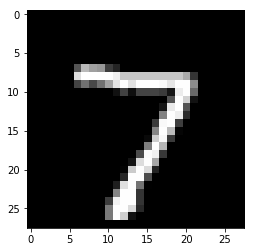

In [11]:
examples = enumerate(data_test)
batch_idx, (example_data, example_targets) = next(examples)
print("Predicted Class: ", 
      np.argmax(model.forward(example_data[0].unsqueeze_(0).cuda()).cpu().detach().numpy()))

plt.imshow(example_data[0].cuda().cpu().detach().numpy()[0], cmap='gray')
# transforms.functional.to_pil_image(example_data[0])

# Scale Invariance 

So far, we just trained the MNIST data set using LeNet 5  model. Since now on, we are going to heads up to the goal of this assignment which is investigating scale invariance problem in CNN models, specifically LeNet 5 model.

In order to work on this problem, firstly, we define a scaling function which can resize and scale images of the MNIST data set.

# Custom Scaling Function
Here the Customscaling function is defined. Using this function, we can scale the images up/down to certain values.

In [12]:
class CustomScaling(object):
    """Rotate image by a fixed angle which is ready for tranform.Compose()
    """

    def __init__(self, scale, angle=0, translate=[0,0], shear=0):
        self.scale = scale
        self.angle = angle
        self.translate = translate
        self.shear = shear

    def __call__(self, img):
        
        return transforms.ToTensor()(
            transforms.functional.affine(
                transforms.ToPILImage()(img), 
                self.angle, self.translate, self.scale, self.shear))

In [13]:
def test_scaled():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad(): # volatile was removed and now 
            # has no effect. Use `with torch.no_grad():` instead.
            data= Variable(data)
        target = Variable(target)
        output = model(data)
        # sum up batch loss # size_average and reduce args will 
        # be deprecated, please use reduction='sum' instead.
        test_loss += F.nll_loss(output, target, reduction='sum').data 
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [14]:
# args['train_now']=False
# args['epochs']=10
# if args['train_now']:
#     for epoch in range (1, args['epochs']+1):
#         train(epoch)
#         test()
#     torch.save(model.state_dict(),'./model/lenet5_MNIST.pytrh' )
# else:
#     if args['cuda']:
#         device = torch.device("cuda")
#         model.load_state_dict(torch.load('./model/lenet5_MNIST.pytrh'))
#         model.to(device)
#     else:
#         model.load_state_dict(torch.load('./model/lenet5_MNIST.pytrh'))
#     model_scaled.eval()

# Results
### Down Scaling
Here we define a loop to see the test results of applying Down scaled images on the pre-trained LeNet5 model with original MNIST data set.

In [15]:
t_loss_down=[]
for scale in range  (1,10):
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data/MNIST', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           CustomScaling(scale/10),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args['test_batch_size'], shuffle=False, **kwargs)
    loss_down = test_scaled()
    t_loss_down.append(loss_down)
    print ('Test for scale =',scale/10)


Test set: Average loss: 2.6558, Accuracy: 526/10000 (5%)

Test for scale = 0.1

Test set: Average loss: 3.5879, Accuracy: 616/10000 (6%)

Test for scale = 0.2

Test set: Average loss: 3.3973, Accuracy: 1752/10000 (17%)

Test for scale = 0.3

Test set: Average loss: 2.9798, Accuracy: 2986/10000 (29%)

Test for scale = 0.4

Test set: Average loss: 1.6113, Accuracy: 5388/10000 (53%)

Test for scale = 0.5

Test set: Average loss: 0.7342, Accuracy: 7742/10000 (77%)

Test for scale = 0.6

Test set: Average loss: 0.2708, Accuracy: 9091/10000 (90%)

Test for scale = 0.7

Test set: Average loss: 0.1120, Accuracy: 9643/10000 (96%)

Test for scale = 0.8

Test set: Average loss: 0.0718, Accuracy: 9800/10000 (98%)

Test for scale = 0.9


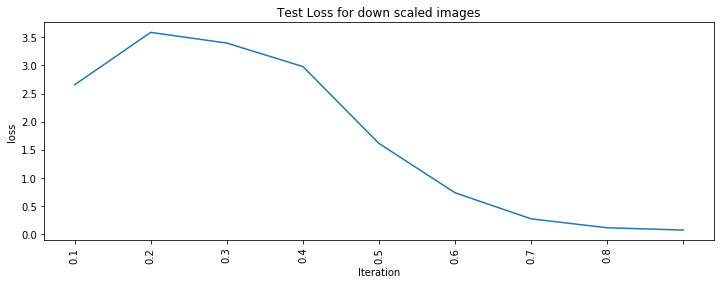

In [17]:
div10 = lambda x:str(x/10)
_len=len(t_loss_down)
rangeofnum = list(map(div10, list(range(1,_len))))
plt.figure(figsize=(12, 4))
plt.plot(t_loss_down)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Test Loss for down scaled images');
plt.savefig('./results/down-sampling')
plt.xticks(range(_len), rangeofnum, rotation='vertical')
plt.show()

### UP Scaling

Here we define a loop to see the test results of applying up scaled images on the pre-trained LeNet5 model with original MNIST data set.

In [19]:
t_loss_up=[]
for scale in range  (11,20):
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data/MNIST', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           CustomScaling(scale/10),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args['test_batch_size'], shuffle=False, **kwargs)
    loss_up = test_scaled()
    t_loss_up.append(loss_up)
    print('Test for scale =',scale/10)


Test set: Average loss: 0.0449, Accuracy: 9870/10000 (98%)

Test for scale = 1.1

Test set: Average loss: 0.0641, Accuracy: 9833/10000 (98%)

Test for scale = 1.2

Test set: Average loss: 0.1583, Accuracy: 9659/10000 (96%)

Test for scale = 1.3

Test set: Average loss: 0.3662, Accuracy: 9328/10000 (93%)

Test for scale = 1.4

Test set: Average loss: 0.7465, Accuracy: 8850/10000 (88%)

Test for scale = 1.5

Test set: Average loss: 1.3189, Accuracy: 8047/10000 (80%)

Test for scale = 1.6

Test set: Average loss: 2.0229, Accuracy: 7229/10000 (72%)

Test for scale = 1.7

Test set: Average loss: 2.7907, Accuracy: 6292/10000 (62%)

Test for scale = 1.8

Test set: Average loss: 3.4815, Accuracy: 5585/10000 (55%)

Test for scale = 1.9


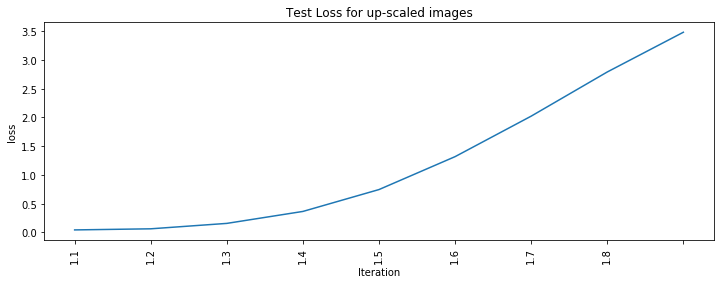

In [48]:
div10 = lambda x:str(x/10+1)
_len=len(t_loss_down)
rangeofnum = list(map(div10, list(range(1,_len))))
plt.figure(figsize=(12, 4))
plt.plot(t_loss_up)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Test Loss for up-scaled images')
plt.savefig('./results/up-sampling')
plt.xticks(range(_len), rangeofnum, rotation='vertical')
plt.show()

# Concolusion

As it is presented above for Down-scaling case there is an acceptable value for loss (lower than 1) when we downscale down to 60% and for the Up-scaling case we can acquire the same loss (lower than 1) when we scale up to 160% of the original image,

To sum up, CNN models are not generaly Scale-Invariance, although as it is represented above, there are some ranges that we can get an acceptable result.

# Reference

Xu, Y., Xiao, T., Zhang, J., Yang, K., & Zhang, Z. (2014). Scale-invariant convolutional neural networks. arXiv preprint arXiv:1411.6369.


Kanazawa, A., Sharma, A., & Jacobs, D. (2014). Locally scale-invariant convolutional neural networks. arXiv preprint arXiv:1412.5104.
